# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**Подробнее о данных:**
- **```RowNumber```** — индекс строки в данных
- **```CustomerId```** — уникальный идентификатор клиента
- **```Surname```** — фамилия
- **```CreditScore```** — кредитный рейтинг
- **```Geography```** — страна проживания
- **```Gender```** — пол
- **```Age```** — возраст
- **```Tenure```** — сколько лет человек является клиентом банка
- **```Balance```** — баланс на счёте
- **```NumOfProducts```** — количество продуктов банка, используемых клиентом
- **```HasCrCard```** — наличие кредитной карты
- **```IsActiveMember```** — активность клиента
- **```EstimatedSalary```** — предполагаемая зарплата

Целевой признак:
- **```Exited```** — факт ухода клиента


**Наша задача:** необходимо построить модель со значением *F1*-меры не менее 0.59 на тестовой выборке. Дополнительно для сравнения измерять *AUC-ROC*.

Оригинальный датасет [лежит здесь.](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### **План действий:**
1) **Подготовка данных** 
  - посмотрим на признаки
  - обработаем пропуски
  - соберём большую чать кода в отдельные блоки, сделав тем самым основную часть кода чуть чище
2) **Исследование ML-моделей с разными гиперпараметрами**. 
  - последовательно по очереди для каждого алгоритма будем рассматривать несколько вариантов ML-моделей: 
    - с дефолтными параметрами и 
    - с подобранными "лучшими параметрами"
  - для каждой модели будем считать метрики
  - в конце получим одну сводную таблицу, по ней выберем для себя самую подходящую модель
  - Рассмотрим следующие алгоритмы:
    - *LogisticRegression*
    - *Support Vector Machines*
    - *RandomForestClassifier*
    - *GradientBoostingClassifier*
3) **Проведём финальное тестирование** на отложенной выборке
4) **Подведём общий итог** проделанной работе

**Важное примечание!** Код отрабатывает полностью где-то за полчаса

_____
_____

## Подготовка данных

Техническая важная часть работы:

**1)** Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 1000)

# для отрисовки графиков
import matplotlib.pyplot as plt
import seaborn as sns

# для пайплайна
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# алгоритмы ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

# метрики
from sklearn.metrics import (roc_curve, auc, roc_auc_score, f1_score, 
                             confusion_matrix, precision_score, recall_score)

# для заполнения пропусков
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import mode
import joblib

# чтоб лог.регрессия не ругалась
import warnings
warnings.filterwarnings('ignore')

# одно значение для всех
random_state = 55555

**2)** вот такие классы и функции будем использовать:
- функция ```plot_confusion_matrix``` - отрисовывает матрицу ошибок и ROC-кривую в фигуре формата 1:2
- функция ```rename_keys``` - убирает префикс из названия параметров в GridSearchCV
- функция ```features_creator``` - для реализации балансировки метки путём создания заданного количества фиктивных признаков "недостающему" классу
- функция ```downsample``` - для реализации *downsample*-балансировки метки
- класс ```DataFrameEditor``` - в нём обучается пайплайн и формируется сводный датафрейм

а вот эти 4 класса взяты с [Kaggle](https://www.kaggle.com/code/atrigo/classification-with-nlp-xgboost-and-pipelines) и немного переписаны под наши задачи:
- класс ```FeatureSelector``` - выбирает признаки для пайплайна
- класс ```NumberSelector``` - тоже выбирает признаки для папплайна, но цифровые, возвращает из них датафрейм 
- класс ```OHEEncoder``` - делает dummy-кодирование для пайплайна
- класс ```NumericPower``` - генерирует новые признаки для пайплайна, возводя старые в степень + логарифм

In [2]:
def plot_confusion_matrix(cnf_matrix, y_test, preds):
    """функция для отрисовки confusion_matrix и ROC-кривой"""
    
    cmap = sns.color_palette('light:#5A9', as_cmap=True)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
    ax1, ax2 = ax.flatten()

    sns.heatmap(cnf_matrix, annot=True, cmap=cmap, fmt='g', linewidths=5, vmin=10, ax=ax[0])
    ax1.set_xlabel('предсказанные значения')
    ax1.set_ylabel('истинные значения')
    ax1.set_title(f'матрица ошибок\n[TN, FP]\n[FN, TP]')

    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='#009B52', lw=2, label=f'ROC curve (S={roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='#20959B', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('FPR', fontweight='bold')
    ax2.set_ylabel('TPR', fontweight='bold')
    ax2.set_title('ROC-кривая')
    ax2.legend(loc='lower right')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.get_xaxis().tick_bottom()
    ax2.get_yaxis().tick_left()
    ax2.grid(linewidth=0.25);
    

def rename_keys(d, prefix):
    """функция убирает префикс из названия ключа"""
    
    return {k.replace(prefix, ''): v for k, v in d.items()}


def features_creator(X_train, y_train, n_new_features, scale=0.1, label=1):
    """функция для балансировки признаков"""
    
    np.random.seed(random_state)
    # категориальные и бинарные/вещественные
    numeric_X = X_train[['balance', 'estimated_salary']]
    categorical_X = X_train[['credit_score', 'geography', 'tenure', 'num_of_products', 
                                   'age', 'gender', 'has_cr_card', 'is_active_member']]
    n_samples = numeric_X.shape[1]                    # количество столбцов
    modes = mode(numeric_X, axis=0)[0].reshape(-1, 1) # моды по числовым столбцам
    
    # Создаем новые признаки с добавлением шума
    new_features = np.random.normal(loc=modes, scale=0.1, size=(n_samples, n_new_features))
    # формируем датафрейм
    X = pd.DataFrame(new_features.T, columns=numeric_X.columns)
    # формируем категориальные признаки обратно, выбирая для каждой строки случайное значение
    for col in categorical_X.columns:
        X[col] = ''
        X[col] = X[col].apply(lambda x: np.random.choice(categorical_X[col]))

    X = X.loc[:, X_train.columns]   # делаем порядок столбцов правильным
    Y = pd.Series([label] * n_new_features) # создаём таргет
    changed_X = pd.concat([X_train] + [X])
    changed_Y = pd.concat([y_train] + [Y])
    return changed_X, changed_Y


def downsample(features, target, fraction):
    """downsample-балансировка"""
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=random_state)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=random_state)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=random_state)
    return features_downsampled, target_downsampled


class DataFrameEditor:
    """класс формирует сводный датафрейм со значениями метрик"""
    
    def __init__(self, df=None):
        if df is None:
            self.df = pd.DataFrame(columns=['name_model', 'F1_predict', 
                                            'Precision', 'Recall', 'ROC AUC'])
        else:
            self.df = df
    
    def add_row(self, values_dict):
        """метод добавляет новые строки в датафрейм"""
        new_row = pd.DataFrame(values_dict, index=[0])
        self.df = pd.concat([self.df, new_row], ignore_index=True)
    
    
    def model_performance_report(self, pipeline, X_train, X_test, y_train, y_test, 
                                 name_model, add_random_features=False, downsampling=False, not_plot=False):
        """в методе обучается модель по переданным параметрам"""

        if add_random_features:
            X_train_, y_train_ = features_creator(X_train, y_train, add_random_features)
            pipeline.fit(X_train_, y_train_)
        elif downsampling:
            X_train_, y_train_ = downsample(X_train, y_train, downsampling)
            pipeline.fit(X_train_, y_train_)
        else:
            pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        f1_predict = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        ROC_AUC = roc_auc_score(y_test, y_pred)
        
        cnf_matrix = confusion_matrix(y_test, y_pred)
        
        if not not_plot:
            plot_confusion_matrix(cnf_matrix, y_test, y_pred_proba)
        
        self.add_row({'name_model': name_model, 'F1_predict': [f1_predict], 
                      'Precision': [precision], 'Recall': [recall], 'ROC AUC': [ROC_AUC]}) 

In [3]:
# классы для Pipeline

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key, drop_first=True).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, drop_first=True)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        self.p = 2

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index, columns =[self.columns] )
        return B[self.columns]
    
pipeline_list = list()

_____

Качаем датасет:

In [4]:
try:
    df = pd.read_csv('Churn.csv')
except FileNotFoundError:
    df = pd.read_csv('https://')

Посмотрим, что есть:

In [5]:
display(df.head(), df.tail(), df.describe().T)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


Заменим названия столбцов, сделаем их в стиле snake_case:

In [6]:
for i, s in enumerate(df.columns):
    s = ''.join(['_' + c.lower() if c.isupper() else c for c in s]).lstrip('_')
    df = df.rename(columns={df.columns[i]: s})

Приведём ещё все строковые значения в таблице к нижнему регистру и удалим в них возможные лишние пробелы между словами. Порядок в таблице в дальнейшем нам может пригодиться:

In [7]:
for i in ['surname', 'geography', 'gender']:
    df[i] = df[i].str.lower().str.strip()

Дубликаты не нашли:

In [8]:
df.duplicated().sum()

0

Посмотрим на тип данных и пропуски:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [10]:
num_cols, cat_cols = [], []
for num, i in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[i]):
        print(f'{num+1}) {i} (числовой), оригинальных значений: {len(df[i].unique())}')
        num_cols.append(i)
    elif pd.api.types.is_object_dtype(df[i]):
        print(f'{num+1}) {i} (категориальный), оригинальных значений: {len(df[i].unique())}')
        cat_cols.append(i)
print(f'\nитого:\nчисловых: {len(num_cols)}\nкатегориальных: {len(cat_cols)}')    

1) row_number (числовой), оригинальных значений: 10000
2) customer_id (числовой), оригинальных значений: 10000
3) surname (категориальный), оригинальных значений: 2931
4) credit_score (числовой), оригинальных значений: 460
5) geography (категориальный), оригинальных значений: 3
6) gender (категориальный), оригинальных значений: 2
7) age (числовой), оригинальных значений: 70
8) tenure (числовой), оригинальных значений: 12
9) balance (числовой), оригинальных значений: 6382
10) num_of_products (числовой), оригинальных значений: 4
11) has_cr_card (числовой), оригинальных значений: 2
12) is_active_member (числовой), оригинальных значений: 2
13) estimated_salary (числовой), оригинальных значений: 9999
14) exited (числовой), оригинальных значений: 2

итого:
числовых: 11
категориальных: 3


**Итого, что предварительно видим по признакам:**

- ```row_number``` и ```customer_id``` - по сути и тот и другой - id записи, в каждом по 10000 неповторяющихся значений, могут мешать обучению
- ```surname``` - категориальный, с большим количеством фамилий, тоже может мешать ML
- ```credit_score``` - тип int, пропусков нет
- ```geography``` - три страны, (Франция, Испания, Германия), применим к нему OHE-кодирование
- ```age``` - от 18-ти до 92-х, куда оттекают 92-хлетние, интересно?))
- ```tenure``` - признак числовой, минимум 0, максимум 10, при этом тип float и есть пропуски - порядка 10% данных, примем решение по пропускам и поменяем тип данных на целочисленный
- ```balance``` - тип float, пропусков нет
- ```num_of_products``` - количество продуктов банка, тип int
- ```gender```, ```has_cr_card```, ```is_active_member``` - бинарные, без пропусков
- ```estimated_salary``` - тип float
- ```exited``` - целевой признак

Удалим признаки с индексами и фамилиями:

In [11]:
df.drop(columns = ['row_number','customer_id','surname'], inplace = True)

Посмотрим на ```tenure``` и пропуски в нём:

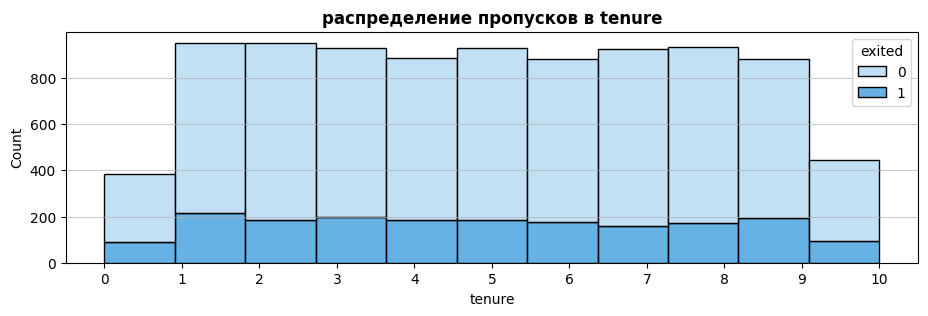

In [12]:
plt.figure(figsize=(11, 3))
sns.histplot(df, x=df.tenure, hue=df.exited, multiple='stack', bins=11,
            palette=['#AED6F1', '#3498DB'])
plt.xticks(range(11))
plt.title('распределение пропусков в tenure', fontweight='bold')
plt.grid(axis='y', linewidth=0.5);

Cвязи оттока с пропусками в признаке ```tenure``` не видно, все 11 вариантов значений (сколько лет человек является клиентом банка) имеют довольно равномерное распределение, как и количество клиентов в оттоке по годам. Чтоб не терять 10% выборки, заполним их с помощью ```IterativeImputer``` (этот алгоритм итерационно заполнит пропуски исходя из соседних значений признака) и переведём признак в целочисленный тип:

In [13]:
# было
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [14]:
imputer = IterativeImputer(max_iter=20, verbose=2)

df['tenure'] = np.round(imputer.fit_transform(df[['tenure']]))
df['tenure'] = df['tenure'].astype(int)

In [15]:
# стало
df['tenure'].describe()

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: tenure, dtype: float64

_____

Разбиваем данные на train, valid и test в соотношении 3:1:1, с применением стратификации при разбиении, это позволит нам сохранить баланс классов в каждой выборке.

In [16]:
# бьём на train и test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='exited'), df['exited'], test_size=.4, random_state=random_state, stratify=df['exited'])

# и разбиваем test пополам -  на test и valid. Они будуи составлять по 20% от df
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=.5, random_state=random_state, stratify=y_test)

Посмотрим получившиеся размеры:

In [17]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((6000, 10), (6000,), (2000, 10), (2000,), (2000, 10), (2000,))

In [18]:
print(f'доля X_test = {X_test.shape[0]/df.shape[0]:.2%}')

доля X_test = 20.00%


Проверим соотношение классов, оно должно быть в равных пропорциях во всех выборках:

In [19]:
y_train.value_counts(), y_valid.value_counts(), y_test.value_counts()

(0    4778
 1    1222
 Name: exited, dtype: int64,
 0    1592
 1     408
 Name: exited, dtype: int64,
 0    1593
 1     407
 Name: exited, dtype: int64)

_____

Подготовим списки признаков для пайплайна:
- ```categorial_columns``` - их прогоним через dummy-преобразование
- ```numeric_colimns``` - на их основе сгенерируем новых признаков с помощью возведения в степень имеющихся + логарифма
- ```bin_columns``` просто пропустим через пайплайн и оставим без трансформаций

In [20]:
categorial_columns = ['geography', 'gender']
numeric_colimns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
bin_columns = ['has_cr_card', 'is_active_member']

Этап предобработки данных (data preprocessing): 

In [21]:
final_transformers = list()
for cat_col in categorial_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))])
    final_transformers.append((cat_col, cat_transformer))

for num_col in numeric_colimns:
    num_transformer = Pipeline([
        ('selector', NumberSelector(key=num_col)),
        ('pow_2', NumericPower(key=num_col)),
        ('scaler', StandardScaler())])
    final_transformers.append((num_col, num_transformer))

for bin_col in bin_columns:
    bin_transformer = Pipeline([
        ('selector', FeatureSelector(column=bin_col))])
    
feats = FeatureUnion(final_transformers)

**Предварительный вывод**:

для подготовки к дальнейшему исследованию данных на данном этапе мы:
- загрузили данные и познакомились с ними
- при помощи ```IterativeImputer``` из ```sklearn.experimental``` заполнили недостающие пропуски в признаке ```tenure```
- подготовили ряд функций и классов для дальнейшей работы
- разделили данные на *train*, *valid* и *test* в соотношении 3:1:1, с применением стратификации
- с помощью ```FeatureUnion``` подготовили пайплайн для обработки признаков: 
  - цифровые признаки будут стандартизироваться и на их основе будут генерироваться новые признаки
  - категориальные признаки прогоняем через pd.get_dummies
  - бинарные оставлем как есть

## Исследование задачи

В исследовании мы рассмотрим несколько моделей Machine learning, будет учиться на трейне, предсказывать на валиде, а значения метрик собирать в единый датафрейм, в конце исследования выберем лучший алгоритм

Проблема в том, что у нас дисбаланс классов в целевой переменной, значения представлены в соотношении 1:4:

In [22]:
f'{df[df.exited == 1].shape[0] / df[df.exited == 0].shape[0]:.2%}'

'25.58%'

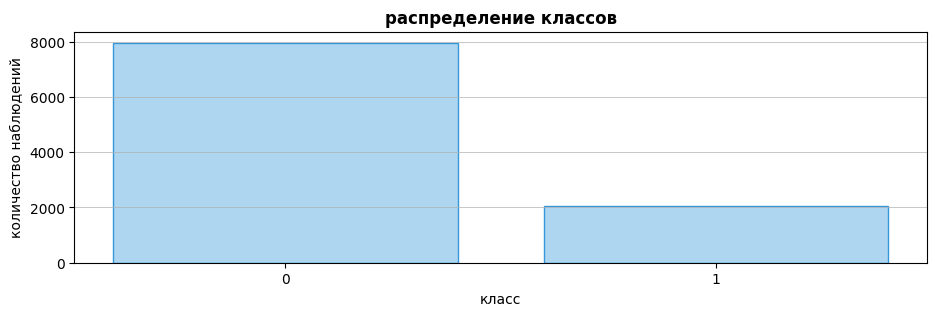

In [23]:
plt.figure(figsize=(11, 3))
unique, counts = np.unique(df.exited, return_counts=True)
plt.bar(unique, counts, color='#AED6F1', ec='#3498DB')
plt.xticks(unique)
plt.xlabel('класс')
plt.ylabel('количество наблюдений')
plt.title('распределение классов', fontweight='bold')
plt.grid(axis='y', linewidth=0.5);

Попробуем применить разные подходы к решению этой проблемы относительно каждого алгоритма. Сделаем так:
- каждый из рассматриваемых алгоритмов применим без каких-либо корректировок с дефолтными настройками
- после чего к дефолтным настройкам добавим ручкую регулировку веса *class_weight={0:1, 1:4}*, тем самым выравнивая классы
- в третьем способе при помощи ```GridSearchCV``` постараемся добиться лучших значений классификации
Для каждого алгоритма рассмотрим такие значения метрик:
- ```F1_predict``` - значение F-меры при предсказании класса
- ```Precision```	- доля правильно предсказанных 1 от всех 1
- ```Recall``` - это доля правильно предсказанных 1 от всех реальных 1
- ```ROC AUC```	- оценка того, насколько хорошо модель разделяет 0 и 1, значение ```площади под ROC-кривой``` будет отмечено в легендах графика

В нашей работе по условию задачи мы ориентируемся за значение ```F-меры``` как среднего гармонического полноты(```Recall```) и точности(```Precision```), но будем присматриваться и к полноте(```Recall```), так как она позволяет оценить способность модели правильно классифицировать 1 (отток клиентов банка). Ошибка в пропуске уходящего клиента может стоить банку дороже, чем ложное определение клиента как уходящего. 

Для большинства моделей нарисуем графиков красивых: матрицу ошибок и ```ROC-кривую``` со значением площади под кривой

Все значения метрик (кроме площади под кривой) будем собирать в сводный датафрейм

_____

### LogisticRegression

Для начала попробуем применить ```LogisticRegression``` "как есть", без перебора параметров и балансировки целевой переменной:

,name_model,F1_predict,Precision,Recall,ROC AUC
0,"LogisticRegression(random_state=55555, solver='liblinear')",0.442539,0.737143,0.316176,0.643641


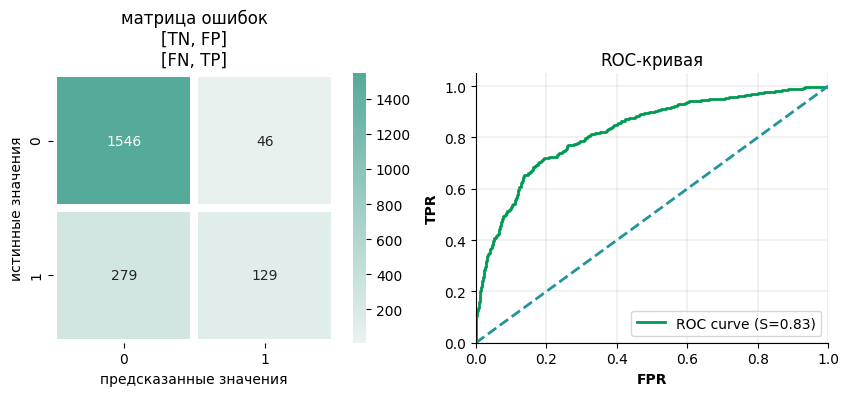

In [24]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(solver='liblinear', random_state=random_state))])
pipeline_list.append(pipeline)
LR_df_editor = DataFrameEditor()
LR_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
LR_df_editor.df.iloc[[-1]]

Что видим - значение *F1* при предсказании класса равно 0.442, полнота очень низкая, с такой моделью мы всех упустим и не заметим этого)

Теперь попробуем "вручную" указать вес первого класса:

,name_model,F1_predict,Precision,Recall,ROC AUC
1,"LogisticRegression(class_weight={0: 1, 1: 4}, random_state=55555,\n solver='liblinear')",0.543723,0.420348,0.769608,0.748811


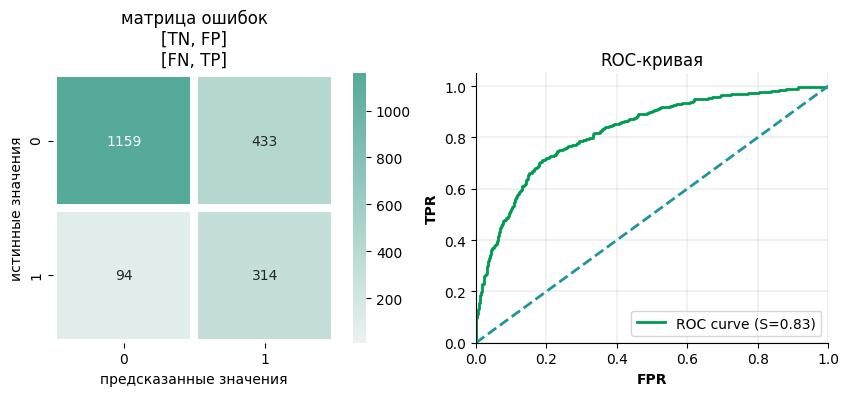

In [25]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(class_weight={0:1, 1:4}, solver='liblinear', random_state=random_state))])
pipeline_list.append(pipeline)
LR_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
LR_df_editor.df.iloc[[-1]]

Значение F1 стало ощутимо выше! А полнота поднялась почти в 2.5 раза! Точность же упала.

Теперь перебрём несколько параметров линейной регрессии с помощью ```GridSearchCV```, посмотрим на:
- ```С``` - это обратный коэффициент регуляризации, контролирующий, насколько сильно модель будет штрафовать за большие значения весов признаков. Малые значения C означают более сильную регуляризацию, а большие значения, соответственно, ослабляют её.
- ```tol``` - это критерий останова алгоритма, определяющий минимально допустимое значение при сравнении двух последних итераций (сравнивается Евклидово расстояние между векторами весов). При достижении допустимого порога алгоритм останавливается.
- ```intercept_scaling``` - масштабирование интерсепта. По умолчанию значение = 1, при котором свободный член не масштабируется. Но он же тоже может вносить свой вклад в банансировку весов признаков, так что покрутим его в бóльшую и меньшую стороны
- ```class_weight``` - вес классов для нашей несбалансированной выборки. Посмотрим значения, которые рассматривали ранее (это {0:1, 1:4} и None) и добавим к ним автоматическую балансировку 'balanced', кто-то из них в сочетании с другими критериями них окажется лучшим

In [26]:
%%time
params = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__tol': [1e-4, 1e-5, 1e-6],
    'classifier__intercept_scaling': [0.5, 1, 1.5, 2],
    'classifier__class_weight': [{0:1, 1:4}, 'balanced', None],
}
grid = GridSearchCV(pipeline, param_grid=params, cv=6, scoring='f1', refit=False, n_jobs=-1)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: total: 29.2 s
Wall time: 57.3 s


{'classifier__C': 100,
 'classifier__class_weight': 'balanced',
 'classifier__intercept_scaling': 0.5,
 'classifier__tol': 0.0001}

,name_model,F1_predict,Precision,Recall,ROC AUC
2,"LogisticRegression(C=100, class_weight='balanced', intercept_scaling=0.5,\n random_state=55555)",0.549605,0.428181,0.767157,0.752297


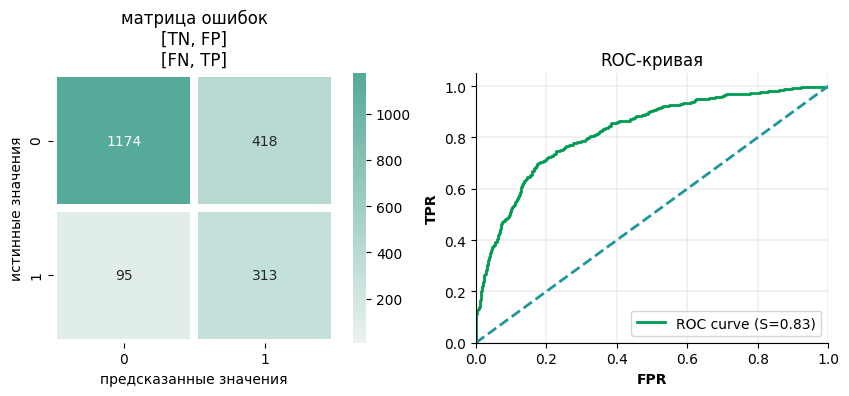

In [27]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(**best_params, random_state=random_state)),])
pipeline_list.append(pipeline)
LR_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
LR_df_editor.df.iloc[[-1]]

Балансировка class_weight=balanced в сочетании с перебором других гиперпараметров показала практически аналогичный результат по метрикам, что и наша ручная балансировка с изменением одного параметра.

In [28]:
LR_df_editor.df.sort_values('F1_predict', ascending=False)

,name_model,F1_predict,Precision,Recall,ROC AUC
2,"LogisticRegression(C=100, class_weight='balanced', intercept_scaling=0.5,\n random_state=55555)",0.549605,0.428181,0.767157,0.752297
1,"LogisticRegression(class_weight={0: 1, 1: 4}, random_state=55555,\n solver='liblinear')",0.543723,0.420348,0.769608,0.748811
0,"LogisticRegression(random_state=55555, solver='liblinear')",0.442539,0.737143,0.316176,0.643641


Пожалуй, не будем больше терзать регрессию и попробуем другие алгоритмы

_____

### Support Vector Machines

сначала возьмём SVC "как есть":

,name_model,F1_predict,Precision,Recall,ROC AUC
0,"SVC(probability=True, random_state=55555)",0.51746,0.734234,0.39951,0.681225


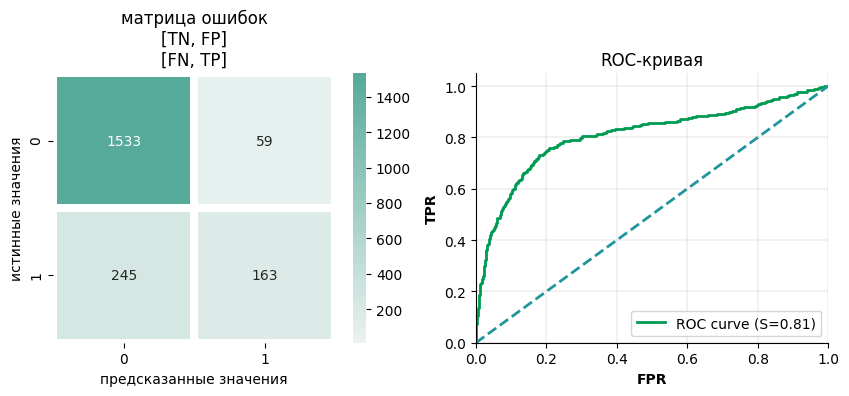

In [29]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', SVC(probability=True, random_state=random_state))])
pipeline_list.append(pipeline)
SVC_df_editor = DataFrameEditor()
SVC_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
SVC_df_editor.df.iloc[[-1]]

Пока значение F-меры не комильфо, низкая полнота, мы не видим отток. И площаь под кривой упала. Плохая получилась модель. 

Попробуем вручную скорректировать вес классов:

,name_model,F1_predict,Precision,Recall,ROC AUC
1,"SVC(class_weight={0: 1, 1: 4}, probability=True, random_state=55555)",0.562444,0.443972,0.767157,0.760463


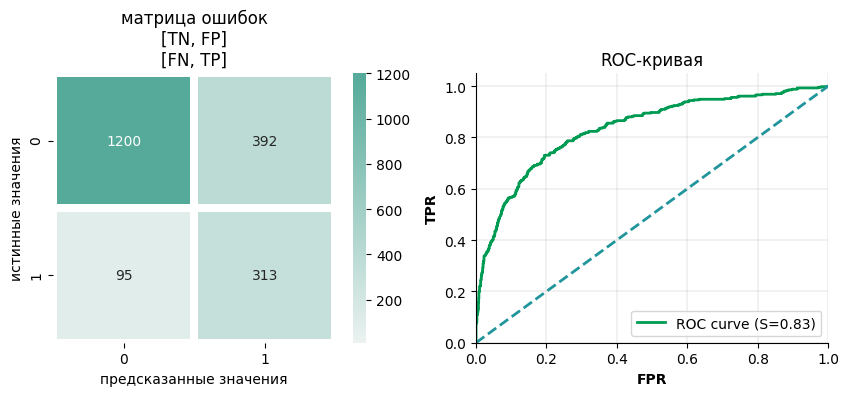

In [30]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', SVC(class_weight={0:1, 1:4}, probability=True, random_state=random_state))])
pipeline_list.append(pipeline)
SVC_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
SVC_df_editor.df.iloc[[-1]]

А с корректировкой веса класса F-мера стала выше, чем при всех вариантах линейной регрессии. И полноа выросла в два с лишним раза! всего 95 уходящих пропустили. Отличный результат! 

Попробуем теперь перебрать в GridSearchCV вот что:
- ```C``` - регуляризация, контролирующая баланс между точностью на обучающей выборке и сложностью модели.
- ```kernel``` - варианты ядра, используемого для преобразования данных в более высокую размерность.
- ```gamma``` параметр, влияющий на гладкость разделяющей гиперплоскости. Чем меньше значение gamma, тем более плавным будет разделительная граница, и наоборот.
- ```class_weight``` - вес классов. Посмотрим  {0:1, 1:4},  None и автоматическую балансировку 'balanced'

больше параметров брать не будем, т.к. SCV алгоритм дорогой и долгий, а у нас впереди ещё деревья и много другого интересного

In [31]:
%%time
params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__class_weight': [{0:1, 1:4}, 'balanced', None],
}
grid = GridSearchCV(pipeline, param_grid=params, cv=6, scoring='f1', refit=False, n_jobs=-1)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: total: 5.47 s
Wall time: 8min 30s


{'classifier__C': 1,
 'classifier__class_weight': 'balanced',
 'classifier__gamma': 'auto',
 'classifier__kernel': 'rbf'}

,name_model,F1_predict,Precision,Recall,ROC AUC
2,"SVC(C=1, class_weight='balanced', gamma='auto', probability=True,\n random_state=55555)",0.572973,0.452991,0.779412,0.769103


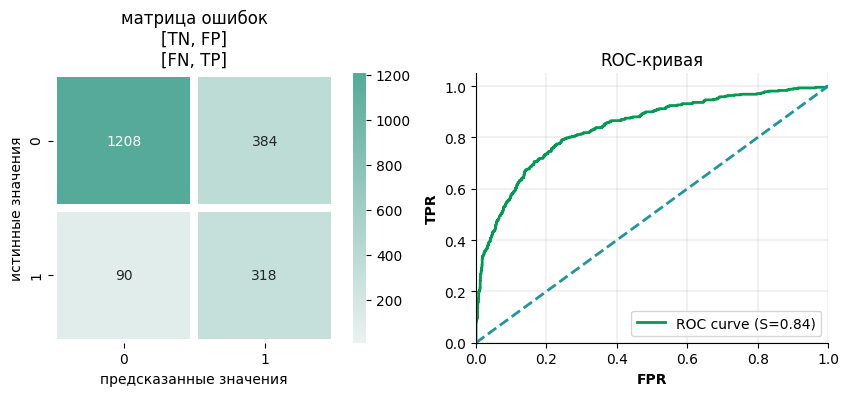

In [32]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', SVC(**best_params, probability=True, random_state=random_state)),])
pipeline_list.append(pipeline)
SVC_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
SVC_df_editor.df.iloc[[-1]]

class_weight=balanced со значением gamma=auto показали лучший вариант из рассмотренных SVC по значению F-меры, а  полнота здорово растёт при балансировке классов! При настройке гиперпараметров и балансировке весов модель SVC показывает великолепный результат по полноте, мы пропустили всего 90 клиентов из оттока и поймали 318

In [33]:
SVC_df_editor.df.sort_values('F1_predict', ascending=False)

,name_model,F1_predict,Precision,Recall,ROC AUC
2,"SVC(C=1, class_weight='balanced', gamma='auto', probability=True,\n random_state=55555)",0.572973,0.452991,0.779412,0.769103
1,"SVC(class_weight={0: 1, 1: 4}, probability=True, random_state=55555)",0.562444,0.443972,0.767157,0.760463
0,"SVC(probability=True, random_state=55555)",0.517460,0.734234,0.399510,0.681225


Перейдём к "деревянным" алгоритмам

_____

### RandomForestClassifier

Сначала дефолтный алгоритм без балансировки класса:

,name_model,F1_predict,Precision,Recall,ROC AUC
0,RandomForestClassifier(random_state=55555),0.542222,0.685393,0.448529,0.697883


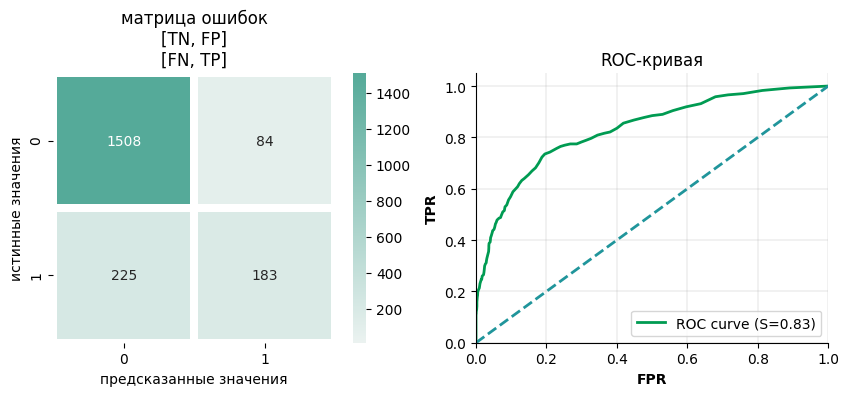

In [34]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=random_state))])
pipeline_list.append(pipeline)
RF_df_editor = DataFrameEditor()
RF_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
RF_df_editor.df.iloc[[-1]]

Ожидаемо не очень. F-мера и Recall низкие. Попробуем сбалансировать целевую переменную и пока больше ничего не трогать:

,name_model,F1_predict,Precision,Recall,ROC AUC
1,"RandomForestClassifier(class_weight={0: 1, 1: 4}, random_state=55555)",0.53092,0.690196,0.431373,0.690875


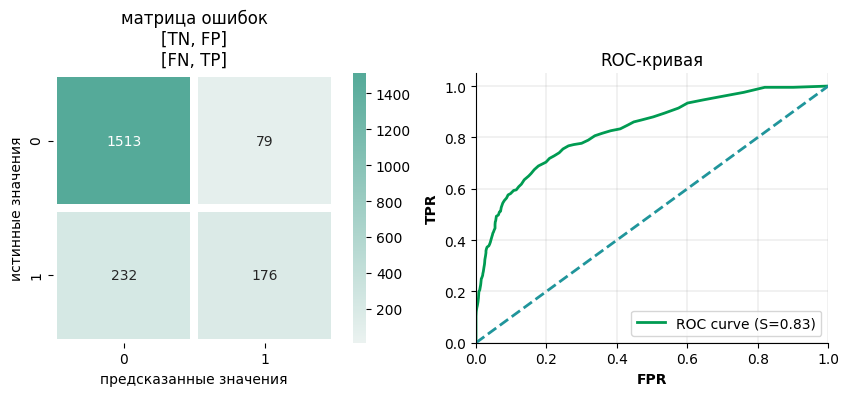

In [35]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(class_weight={0:1, 1:4}, random_state=random_state))])
pipeline_list.append(pipeline)
RF_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
RF_df_editor.df.iloc[[-1]]

По F-мере, полноте и ROC AUC есть незначительная просадка, ручная балансировка классов в лесу никак нам не помогла. Определённо алгоритм SVC справился с задачей лучше.

Подберём гиперпараметры с помощью GridSearchCV. Вот что рассмотрим:
- ```n_estimators``` - количество деревьев в лесу
- ```max_depth``` - максимальная глубина дерева
- ```min_samples_split``` - минимальное количество наблюдений для разбиения узла
- ```class_weight``` - вес наш любимый

In [36]:
%%time
params = {
    'classifier__n_estimators': range(100, 251, 50),
    'classifier__max_depth': [None, 9, 10, 11],
    'classifier__min_samples_split': range(14, 19, 2),
    'classifier__class_weight': [{0:1, 1:4}, 'balanced', None],
}
grid = GridSearchCV(pipeline, param_grid=params, cv=6, scoring='f1', refit=False, n_jobs=-1)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: total: 21.7 s
Wall time: 7min 52s


{'classifier__class_weight': {0: 1, 1: 4},
 'classifier__max_depth': 9,
 'classifier__min_samples_split': 14,
 'classifier__n_estimators': 200}

,name_model,F1_predict,Precision,Recall,ROC AUC
2,"RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=9,\n min_samples_split=14, n_estimators=200,\n random_state=55555)",0.596891,0.517056,0.705882,0.768456


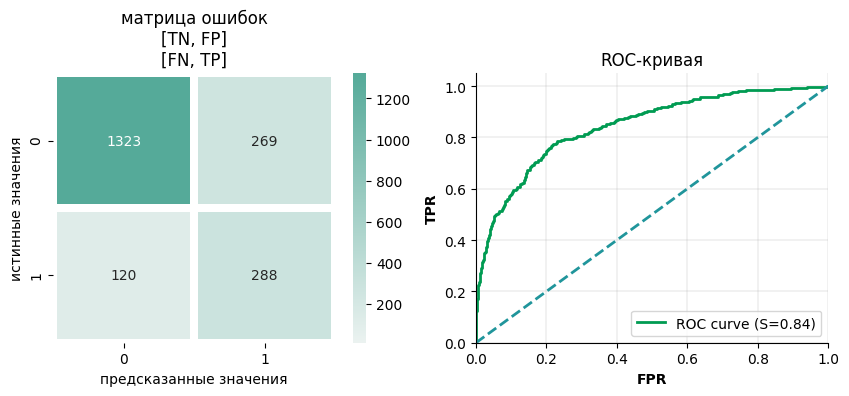

In [37]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(**best_params, random_state=random_state)),])
pipeline_list.append(pipeline)
RF_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
RF_df_editor.df.iloc[[-1]]

А вот случайный лес с перебором гиперпараметров пока дал самый лучший результат по F-мере, при этом, действительно, мы видим высокое значение у Recall, при этом Precision тоже вполне себе ничего смотрится.

Отметим так же, что на этот раз наша ручная балансировка классов оказалась эффективней автоматической, а значит делаем мы её не зря.

In [38]:
RF_df_editor.df.sort_values('F1_predict', ascending=False)

,name_model,F1_predict,Precision,Recall,ROC AUC
2,"RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=9,\n min_samples_split=14, n_estimators=200,\n random_state=55555)",0.596891,0.517056,0.705882,0.768456
0,RandomForestClassifier(random_state=55555),0.542222,0.685393,0.448529,0.697883
1,"RandomForestClassifier(class_weight={0: 1, 1: 4}, random_state=55555)",0.530920,0.690196,0.431373,0.690875


Перейдём к бустингу

_____

### GradientBoostingClassifier

По традиции - первый дефолтный:

,name_model,F1_predict,Precision,Recall,ROC AUC
0,GradientBoostingClassifier(random_state=55555),0.553892,0.711538,0.453431,0.70316


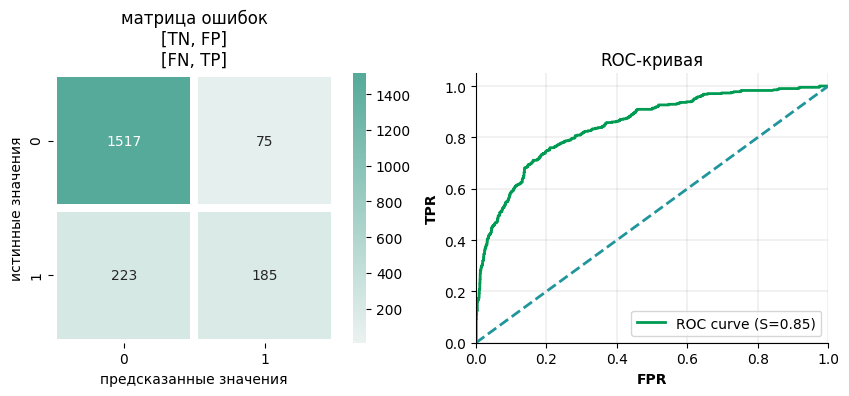

In [39]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=random_state))])
pipeline_list.append(pipeline)
Boosting_df_editor = DataFrameEditor()
Boosting_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, str(pipeline[-1]))
Boosting_df_editor.df.iloc[[-1]]

Пока, как и у всех без балансировки, слабовато.

К сожалению, у градиентного бустинга нет параметра class_weight, поэтому для дальнейшей балансировки классов для GradientBoosting попробуем применить такие методы: 
- *downsampling* - добивается балансировки классов путём уменьшения количества наблюдений для для класса, которого большинство
- *add_random_features* - метод увеличит количество наблюдений для того класса, который мы ему укажем (по умолчанию это 1-й класс, наш). Метод формирует новые наблюдения рандомным выбором из категориальных значений признака, а для цифровых значений применяет моду с добавлением шума scale=0.1

Начнём с *add_random_features*, добавив фиктивных наблюдений в 1-й класс. Напомним себе, на сколько наблюдений класса 1 меньше, чем класса 0, это количество и будем добавлять:

In [40]:
add_features = y_train.value_counts()[0] - y_train.value_counts()[1]
add_features

3556

,name_model,F1_predict,Precision,Recall,ROC AUC
1,GradientBoostingClassifier(random_state=55555)+add_random_features,0.546003,0.709804,0.443627,0.698573


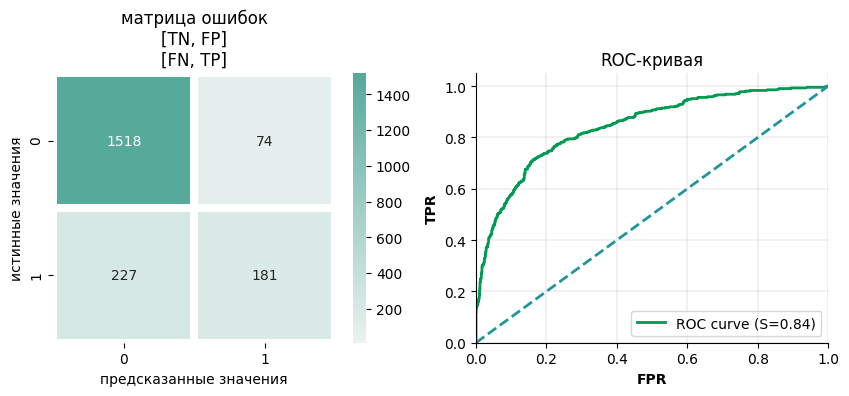

In [41]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=random_state))])
pipeline_list.append(pipeline)
Boosting_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, 
                                            str(pipeline[-1])+'+add_random_features', add_random_features=add_features)
Boosting_df_editor.df.iloc[[-1]]

Принципиальных изменеий нет, добавление фиктивных признаков не сделало модель лучше.

Попробуем теперь *downsample* и уменьшим количество наблюдений в классе 0:

,name_model,F1_predict,Precision,Recall,ROC AUC
2,GradientBoostingClassifier(random_state=55555)+downsampling,0.595528,0.508681,0.718137,0.770187


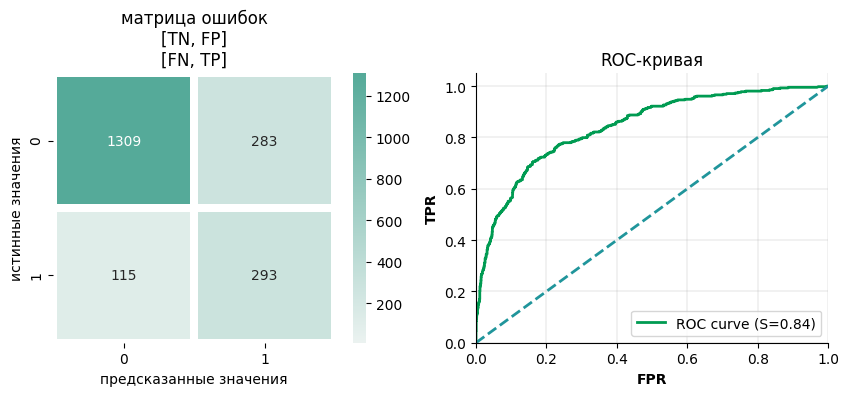

In [42]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=random_state))])
pipeline_list.append(pipeline)
Boosting_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, 
                                            str(pipeline[-1])+'+downsampling', downsampling=0.33)
Boosting_df_editor.df.iloc[[-1]]

Результат восторг! С применением downsampling F-мера перевалила за 0.59. Высокая полнота, очень приличная точность, ROC_AUC на высоте. Отличный результат.

Переберём и для *downsampling* и для *add_random_features*-методов балансировки классов параметры бустинга в GridSearchCV в поисках лучшей F-меры. Рассмотрим такие параметры:

- ```max_depth``` - глубину деревьев (для бустинга обычно хороши "пеньки")
- ```n_estimators``` - количество базовых алгоритмов (деревьев)
- ```subsample``` - доля объектов обучающей выборки, которая будет использована для обучения каждого базового алгоритма (уменьшение доли может как снизить переобучение со скоростью, так и ухудшить результат, надо экспериментировать)
- ```learning_rate``` - величина шага при обновлении весов базовых алгоритмов в процессе обучения (чем learning_rate больше, тем быстрее обучение, но и риск переобучения выше)

In [43]:
%%time
params = {
    'classifier__max_depth': [2, 6, 8],
    'classifier__n_estimators': range(200, 301, 50),
    'classifier__subsample': [0.7, 1.0],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
}
grid = GridSearchCV(pipeline, param_grid=params, cv=6, scoring='f1', refit=False, n_jobs=-1)
X_train_d, y_train_d = downsample(X_train, y_train, fraction=0.33)
search = grid.fit(X_train_d, y_train_d)
search.best_params_

CPU times: total: 6.91 s
Wall time: 5min 36s


{'classifier__learning_rate': 0.01,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 300,
 'classifier__subsample': 0.7}

,name_model,F1_predict,Precision,Recall,ROC AUC
3,"GradientBoostingClassifier(learning_rate=0.01, max_depth=6, n_estimators=300,\n random_state=55555, subsample=0.7)+downsampling",0.585267,0.497427,0.710784,0.76337


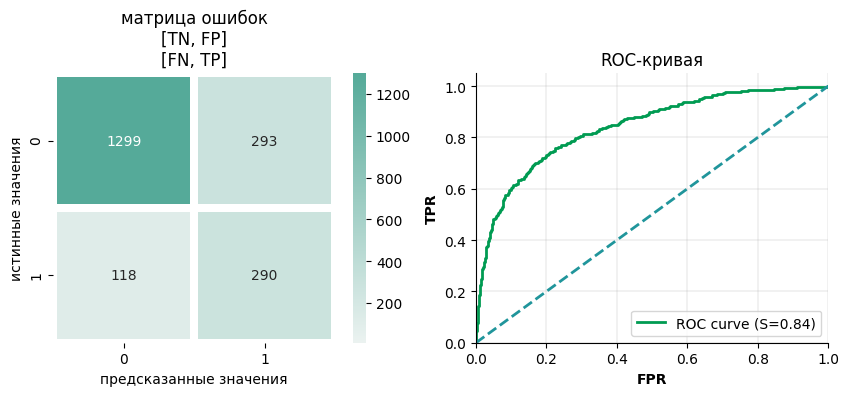

In [44]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(**best_params, random_state=random_state)),])
pipeline_list.append(pipeline)
Boosting_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, 
                                   str(pipeline[-1])+'+downsampling', downsampling=0.33)
Boosting_df_editor.df.iloc[[-1]]

Удивительно, но значение F-меры на параметрах, найденных при помощи GridSearchCV + downsampling, стало чуть хуже дефолтных с применением балансировки *downsampling*. Бывает и такое.

In [45]:
%%time
X_train_u, y_train_u = features_creator(X_train, y_train, n_new_features=add_features)
search = grid.fit(X_train_u, y_train_u)
search.best_params_

CPU times: total: 9.25 s
Wall time: 14min 6s


{'classifier__learning_rate': 0.001,
 'classifier__max_depth': 8,
 'classifier__n_estimators': 250,
 'classifier__subsample': 1.0}

,name_model,F1_predict,Precision,Recall,ROC AUC
4,"GradientBoostingClassifier(learning_rate=0.001, max_depth=8, n_estimators=250,\n random_state=55555)+add_random_features",0.52795,0.720339,0.416667,0.687605


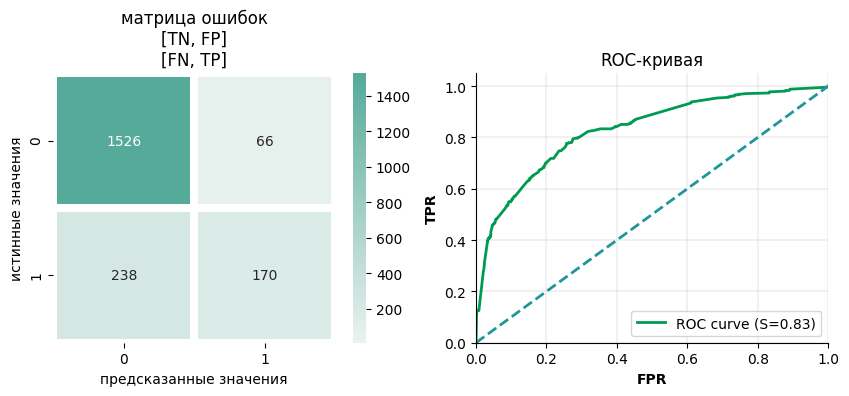

In [46]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(**best_params, random_state=random_state)),])
pipeline_list.append(pipeline)
Boosting_df_editor.model_performance_report(pipeline, X_train, X_valid, y_train, y_valid, 
                                            str(pipeline[-1])+'+add_random_features', add_random_features=add_features)
Boosting_df_editor.df.iloc[[-1]]

А для GridSearchCV + add_random_features результат ещё ниже, крутилось долго, ожиданий не оправдало. 

_____

Подходы ```upsampling``` и ```downsampling``` мы не применяли к дефолтным моделям, для получения полной картины, применим к каждой из них ```upsampling``` и ```downsampling```:

In [47]:
LR_w_df_editor = DataFrameEditor()
for i in [pipeline_list[0], pipeline_list[3], pipeline_list[6]]:
    LR_w_df_editor.model_performance_report(
        i, X_train_d, X_valid, y_train_d, y_valid,
        str(i[-1])+'+downsampling', not_plot=True)
    LR_w_df_editor.model_performance_report(
        i, X_train, X_valid, y_train, y_valid,
        str(i[-1])+'+add_random_features', 
        add_random_features=add_features, not_plot=True)

_____
_____

**Посмотрим на сводную таблицу результатов работы всех рассмотренные моделей:**

In [48]:
(
    pd.concat([LR_df_editor.df, SVC_df_editor.df, 
               RF_df_editor.df, Boosting_df_editor.df, LR_w_df_editor.df], axis=0)
    .reset_index(drop=True).sort_values('F1_predict', ascending=False)
)

,name_model,F1_predict,Precision,Recall,ROC AUC
8,"RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=9,\n min_samples_split=14, n_estimators=200,\n random_state=55555)",0.596891,0.517056,0.705882,0.768456
11,GradientBoostingClassifier(random_state=55555)+downsampling,0.595528,0.508681,0.718137,0.770187
12,"GradientBoostingClassifier(learning_rate=0.01, max_depth=6, n_estimators=300,\n random_state=55555, subsample=0.7)+downsampling",0.585267,0.497427,0.710784,0.763370
16,"SVC(probability=True, random_state=55555)+downsampling",0.584337,0.494898,0.713235,0.763339
5,"SVC(C=1, class_weight='balanced', gamma='auto', probability=True,\n random_state=55555)",0.572973,0.452991,0.779412,0.769103
14,"LogisticRegression(random_state=55555, solver='liblinear')+downsampling",0.568608,0.476033,0.705882,0.753381
18,RandomForestClassifier(random_state=55555)+downsampling,0.567780,0.473770,0.708333,0.753350
4,"SVC(class_weight={0: 1, 1: 4}, probability=True, random_state=55555)",0.562444,0.443972,0.767157,0.760463
9,GradientBoostingClassifier(random_state=55555),0.553892,0.711538,0.453431,0.703160
2,"LogisticRegression(C=100, class_weight='balanced', intercept_scaling=0.5,\n random_state=55555)",0.549605,0.428181,0.767157,0.752297


**Предварительный вывод**:

На данном этапе мы: 
- применили к имеющимся данным 4 алгоритма машинного обучения с разными параметрами
- все алгоритмы мы последовательно рассмотрели как с дефолтными характеристиками, так и с перебором параметро с помощью ```GridSearchCV```
- к каждому алгоритму с дефолтными характеристиками применили *downsampling* и рукописный *add_random_features*-подходы
- собрали значение метрик всех моделей в сводную таблицу, а сами Pipeline каждой модели в отдельный список
- из наблюдений стало очевидно, что:
  - в лучшем результате мы видим не автоматическую балансировку классов, а нашу "ручную", так что применение её было не зря 
  - балансировка * class_weight='balanced'* точно так же даёт отличные результаты.
  - в обоих случая балансировки обращает на себя внимание резний подъём Recall, что для нашей задачи может оказаться на руку.
  - *downsampling* подход улучшает качество предсказания и доказывает свою эффективность
  - При этом модели совсем без балансировки или с балансировкой самописным методом *add_random_features* вернули самые плохие результаты. Особенно хорошо видна разница в результатах работы ```Support Vector Machines```, когда с добавлением балансировки этот алгоритм вернул самое крутов значение полноты - аж 0.779412! Таких цифр больше не дала ни одна модель. ```SVC``` молодец и справился с задачей, найдя оптимальную гиперплоскость между классами.

- Но мы для дальнейшей проверки выберем алгоритм ```RandomForestClassifier```, так как основной ориентир для нас - метрика F1, а случайный лес с подбором гиперпараметров вернул результат F1=0.596891, обогнав остальных. ROC AUC у него тоже на хороших позициях, да и остальные метрики смотрятся хорошо.

_____
_____

## Тестирование модели

Для финальной проверки модели соберём X_train, X_valid обратно в единый датафрейм:

In [49]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

Напомним себе пайплайн выбранного алгоритма:

In [50]:
pipeline_list[8]

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='geography'))])),
                                                ('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('credit_score',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='cr...
                                                                  NumericPower(key='num_of_products')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('estimated_salary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='estimated_salary')),
                                                                 ('pow_2',
                                                                  NumericPower(key='estimated_salary')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=9,
                                        min_samples_split=14, n_estimators=200,
                                        random_state=55555))])

Сохраним пайплайн и модель в файл:

In [51]:
# joblib.dump(pipeline_list[8], 'best_model.joblib')

Предскажем на отложенной выборке и сразу посмотрим на полученные метрики:

In [52]:
final_preds = DataFrameEditor()
final_preds.model_performance_report(pipeline_list[8], 
                                     X, X_test, y, y_test, str(pipeline_list[8][-1]), not_plot=True)
final_preds.df

,name_model,F1_predict,Precision,Recall,ROC AUC
0,"RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=9,\n min_samples_split=14, n_estimators=200,\n random_state=55555)",0.616352,0.537477,0.722359,0.781769


**Предварительный вывод**:

Выбранная нами ML-модель *RandomForestClassifier* справилась с поставленной задачей и показала значение *F-меры* на тестовой выборке даже лучше, чем показывала на тренировочной и валидационной. Выше и все остальные метрики.

_____
_____

## Общий вывод:

Перед нами стояла задача спрогнозировать отток клиентов банка «Бета-Банк» на основании представленных исторических данных о поведении клиентов и расторжении договоров с банком.

**В ходе исследования были проделаны следующие ключевые шаги:**
- обработаны представленные данные - заполнены пропуски, все данные приведены к нижнему регистру
- в ходе обработки даных была проведена и их т.н. предобработка (этап data preprocessing), т.е. подготовлен единый пайплайн
- для формирования ML-моделей были выбраны следующие алгоритмы машинного обучения:
  - *LogisticRegression*
  - *Support Vector Machines*
  - *RandomForestClassifier*
  - *GradientBoostingClassifier*
- для оценки качества моделей были использваны следующие метрики для задач классификации:
- ```F1_predict``` - значение F-меры при предсказании класса
- ```Precision```	- доля правильно предсказанных 1 от всех 1
- ```Recall``` - это доля правильно предсказанных 1 от всех реальных 1
- ```ROC AUC```	- оценка того, насколько хорошо модель разделяет 0 и 1

- для борьбы с дисбалансом классов были применены такие способы:
  - "ручной" подход - указание баланса классов как *class_weight={0: 1, 1: 4}*
  - выбор подхода перебором при помощи GridSearchCV
  - метод *add_random_features*, заключающийся в увеличении количества наблюдений в классе, представленном в меньшей мере, путём генерации псевдопризнаков
  - функция *downsampling*, делающая уменьшение количества наблюдений в классе, представленном в большей мере
- в ходе исследования из 4-х алгоритмов мы получили 20 разных Machine Learning-моделей и метрики каждой собрали в отдельную сводную таблицу
- на основании полученной информации для финального тестирования были выбран алгоритм, показавший лучшее начение F-меры на тренировочных данных (0.596891) и "побивший" свой же рекорд на тестовых данных (0.616352):
  - **RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=9,\n min_samples_split=14, n_estimators=200, random_state=55555)**
- стоит так же отметить алгоритм ```Support Vector Machines```, F-мера у него не самая высокая из представленных (всего 0.572973), зато полнота Recall выше всяких похвал, она составила 0.779412 и при таком значении полноты количество False Negative (FN) равно 90. Если бы акпкд нами стояла задача было максимизировать метрику Recall, мы бы могли смело рекомендовать алгоритм  SVM как действительно качественный подход для решения задачи.
  - SVC(C=1, class_weight='balanced', gamma='auto', probability=True,\n random_state=55555)
- из наблюдений так же видно, что балансировка классов принципиально важна для улучшения всех метрических показателей буквально для всех алгоритмов машинного обучения и моделей, построенных на них, особенно сильно с добавлением балансировки меняются параметры Precision и Recall - Precision падает, Recall растёт.

**Кому может быть полезно данное исследование:**

Непосредственному заказчику работы, банку «Бета-Банк». С целью достижения лучших значений по выявлению клиентского оттока мы, помимо *F-меры* ориентировались так же и на значения метрики *Recall*, так как она позволяет оценить способность модели правильно классифицировать отток клиентов банка (класс 1). Ошибка в пропуске уходящего клиента может стоить банку дороже, чем ложное определение клиента как уходящего. 

**Что могло помешать исследованию:**

Как раз отсутсвие финансовой составляющей и понимания того, в какие деньги банку обходится удержание клиента и какие финансовые издержки несёт банк при потере клиента. За отсутствием данной информации мы руководствовались Data Science-показателями метрик, тогда как финансовые коэффициенты могли бы серьёзно скорректировать результат, ведь в процессе исследовани вполне могло обнаружиться то, что в буквальном слысле "удерживать всех" - экономически нецелесообразно.